In [1]:
# Cell 1: Import libraries
import os
import numpy as np
import librosa
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns


2025-05-17 10:23:51.167620: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-17 10:23:51.177169: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747452231.190030   63852 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747452231.193130   63852 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747452231.201377   63852 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:

# Cell 2: Create features directory
os.makedirs('../data/features/mel', exist_ok=True)

In [3]:

# Cell 3: Define Mel spectrogram extraction function
def extract_mel_spectrogram(audio_path, n_mels=128, n_fft=2048, hop_length=128):
    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)
    
    # Extract mel spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length,
        fmin=20,
        fmax=sr/2,
        power=2.0
    )
    
    # Convert to log scale (dB)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Chuẩn hóa về khoảng [0,1]
    mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
    
    # Resize về kích thước cố định (128, 32)
    mel_spec_norm = tf.image.resize(mel_spec_norm[..., np.newaxis], (128, 32))
    mel_spec_norm = mel_spec_norm.numpy()
    mel_spec_norm = mel_spec_norm[..., 0]
    
    return mel_spec_norm


In [4]:
# def extract_mel_spectrogram_db(audio_path, sr=16000, n_mels=128, n_fft=2048, hop_length=256):
#     # Load audio
#     y, sr = librosa.load(audio_path, sr=sr)

#     # Tính Mel spectrogram (power)
#     mel_spec = librosa.feature.melspectrogram(
#         y=y,
#         sr=sr,
#         n_fft=n_fft,
#         hop_length=hop_length,
#         n_mels=n_mels,
#         fmin=20,
#         fmax=sr / 2,
#         power=2.0
#     )

#     # Chuyển sang dB
#     mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

#     return mel_spec_db

In [5]:
# Cell 4: Get all audio files from processed directory
processed_dir = '../data/processed'
audio_files = []
for root, dirs, files in os.walk(processed_dir):
    for file in files:
        if file.endswith('.wav'):
            audio_files.append(os.path.join(root, file))


In [6]:
# Cell 5: Process each audio file
# Initialize metadata list
metadata = []

# Process each audio file
for audio_path in tqdm(audio_files):
    # Get relative path from processed directory
    rel_path = os.path.relpath(audio_path, processed_dir)
    # Create corresponding directory in features
    feature_dir = os.path.join('../data/features/mel', os.path.dirname(rel_path))
    os.makedirs(feature_dir, exist_ok=True)
    
    # Extract mel spectrogram
    mel_features = extract_mel_spectrogram(audio_path)
    
    # Save features with same name but .npy extension
    feature_path = os.path.join(feature_dir, os.path.splitext(os.path.basename(audio_path))[0] + '.npy')
    np.save(feature_path, mel_features)
    
    # Add to metadata
    metadata.append({
        'audio_path': rel_path,
        'feature_path': os.path.relpath(feature_path, '../data/features/mel'),
        'mel_shape': mel_features.shape,
        'duration': librosa.get_duration(path=audio_path),
        'sr': librosa.get_samplerate(audio_path)
    })

# Convert metadata to DataFrame and save
metadata_df = pd.DataFrame(metadata)
metadata_df.to_csv('../data/features/mel/metadata.csv', index=False)


100%|██████████| 821/821 [00:07<00:00, 103.14it/s]


In [7]:
# Cell 6: Display metadata summary
print("Metadata Summary:")
print(f"Total files processed: {len(metadata_df)}")
print("\nFeature shapes:")
print(metadata_df['mel_shape'].value_counts())
# print("\nSample rate distribution:")
# print(metadata_df['sr'].value_counts())
# print("\nDuration statistics (seconds):")
# print(metadata_df['duration'].describe())

# Display first few rows of metadata
print("\nFirst few entries:")
print(metadata_df.head())

Metadata Summary:
Total files processed: 821

Feature shapes:
mel_shape
(128, 32)    821
Name: count, dtype: int64

First few entries:
                          audio_path                       feature_path  \
0  bat_den/bat_den_speaker01_001.wav  bat_den/bat_den_speaker01_001.npy   
1  bat_den/bat_den_speaker01_002.wav  bat_den/bat_den_speaker01_002.npy   
2  bat_den/bat_den_speaker01_003.wav  bat_den/bat_den_speaker01_003.npy   
3  bat_den/bat_den_speaker01_004.wav  bat_den/bat_den_speaker01_004.npy   
4  bat_den/bat_den_speaker01_005.wav  bat_den/bat_den_speaker01_005.npy   

   mel_shape  duration     sr  
0  (128, 32)       1.0  16000  
1  (128, 32)       1.0  16000  
2  (128, 32)       1.0  16000  
3  (128, 32)       1.0  16000  
4  (128, 32)       1.0  16000  


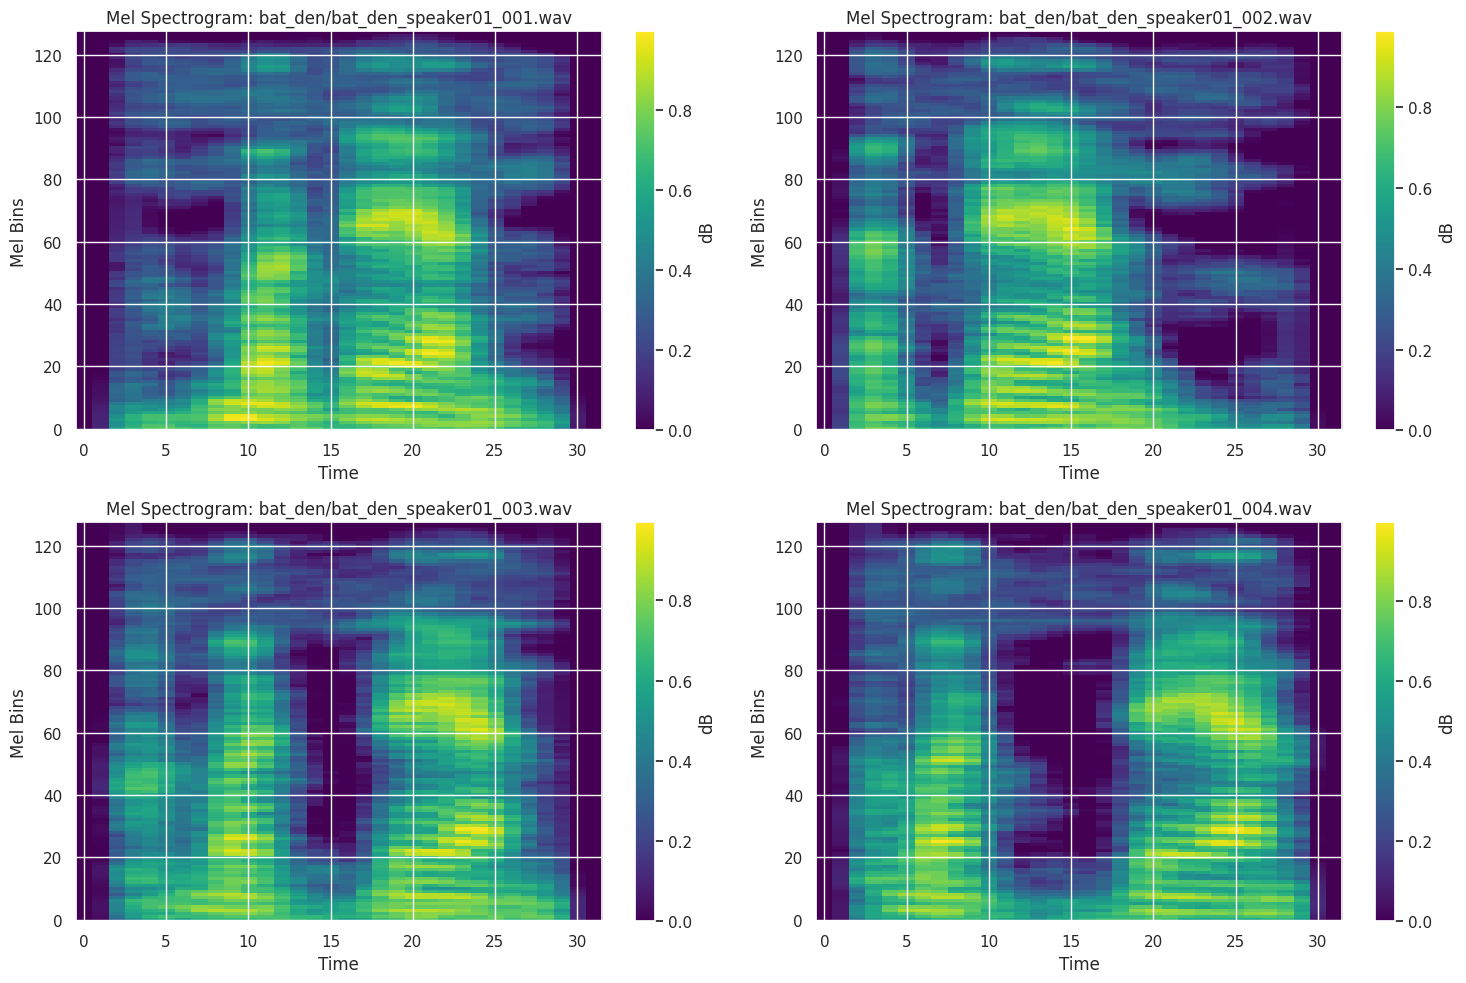

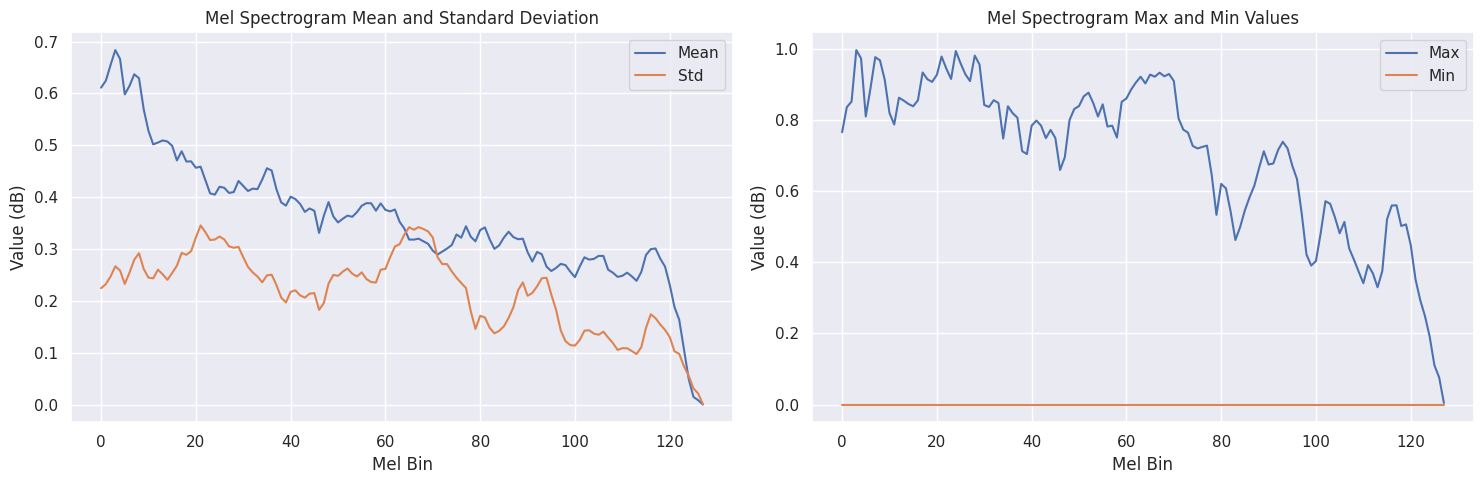

In [8]:
# Cell 7: Visualization
# Set style using seaborn directly to avoid deprecation warning
import seaborn as sns
sns.set_theme()

# 1. Mel Spectrogram Heatmap
plt.figure(figsize=(15, 10))
n_examples = min(4, len(metadata_df))

for i in range(n_examples):
    plt.subplot(2, 2, i+1)
    feature_path = os.path.join('../data/features/mel', metadata_df.iloc[i]['feature_path'])
    mel_features = np.load(feature_path)
    
    plt.imshow(mel_features, aspect='auto', origin='lower', cmap='viridis')
    plt.title(f'Mel Spectrogram: {metadata_df.iloc[i]["audio_path"]}')
    plt.xlabel('Time')
    plt.ylabel('Mel Bins')
    plt.colorbar(label='dB')

plt.tight_layout()
plt.show()

# 2. Mel Spectrogram Statistics
plt.figure(figsize=(15, 5))

feature_path = os.path.join('../data/features/mel', metadata_df.iloc[0]['feature_path'])
mel_features = np.load(feature_path)

plt.subplot(1, 2, 1)
plt.plot(mel_features.mean(axis=1), label='Mean')
plt.plot(mel_features.std(axis=1), label='Std')
plt.title('Mel Spectrogram Mean and Standard Deviation')
plt.xlabel('Mel Bin')
plt.ylabel('Value (dB)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mel_features.max(axis=1), label='Max')
plt.plot(mel_features.min(axis=1), label='Min')
plt.title('Mel Spectrogram Max and Min Values')
plt.xlabel('Mel Bin')
plt.ylabel('Value (dB)')
plt.legend()

plt.tight_layout()
plt.show()